# Symmetric vs asymmetric parcellation


In [2]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.scripts.atlas_paper.parcel_hierarchy as ph
import ProbabilisticParcellation.scripts.atlas_paper.evaluate_atlas as eva
import hierarchical_clustering as cl
from Functional_Fusion.dataset import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import torch as pt


In [3]:
figure_path = "/Users/jdiedrichsen/Dropbox (Diedrichsenlab)/papers/AtlasPaper/figure_parts/"
if not os.path.exists(figure_path):
    figure_path = "/Users/callithrix/Dropbox/AtlasPaper/figure_parts/"
atlas_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'


In [4]:
figsize = (20, 20)
model_pair = ['Models_03/sym_MdPoNiIbWmDeSo_space-MNISymC2_K-68_reordered',
              'Models_03/asym_MdPoNiIbWmDeSo_space-MNISymC2_K-68_arrange-asym_sep-hem_reordered']

atlas = 'MNISymC2'

# Group Symmetry

## Boundary Asymmetry (Group)


In [5]:
# Read in individual and group correlation
asym_sym_corr_group = np.load(f'{ut.model_dir}/Models/{model_pair[0]}_asym_sym_corr_group.npy')

atlas = 'MNISymC2'
dtype = 'func'
cmap = 'hot'
cscale = (0.5, 1)
labels = None,
colorbar = True


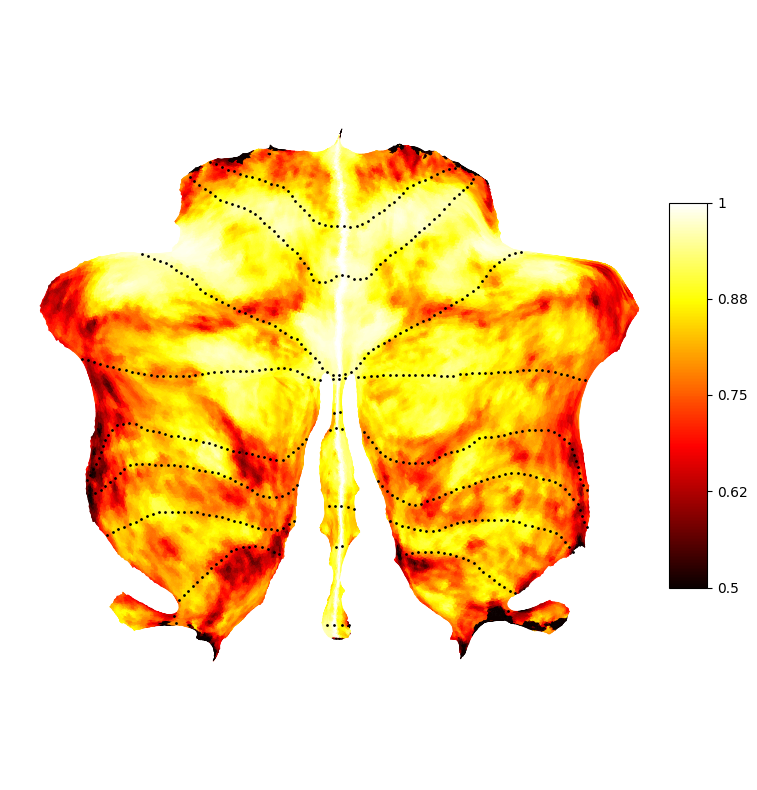

In [6]:

plt.figure(figsize=(10, 10))
ut.plot_data_flat(asym_sym_corr_group, atlas,
                       dtype=dtype,
                       render='matplotlib',
                       cmap='hot',
                       cscale=cscale,
                       labels=labels,
                       colorbar=colorbar)
plt.savefig(figure_path + 'Symmetry_boundary_group_05.png', dpi=300,bbox_inches='tight')


## Functional Asymmetry (Group)

In [7]:
fileparts = model_pair[0].split('/')
split_mn = fileparts[-1].split('_')
info, model = ut.load_batch_best(model_pair[0])

# Get winner take-all
Prob = np.array(model.marginal_prob())
parcel = Prob.argmax(axis=0) + 1

# Get similarity
w_cos, _, _ = cl.parcel_similarity(model, plot=False, sym=False)

# Get the off-diagonal of w_cos: Cross-hemispheric similarity
indx1 = np.arange(model.K)
v = np.arange(model.arrange.K)
indx2 = np.concatenate([v + model.arrange.K, v])
sym_score = w_cos[indx1, indx2]


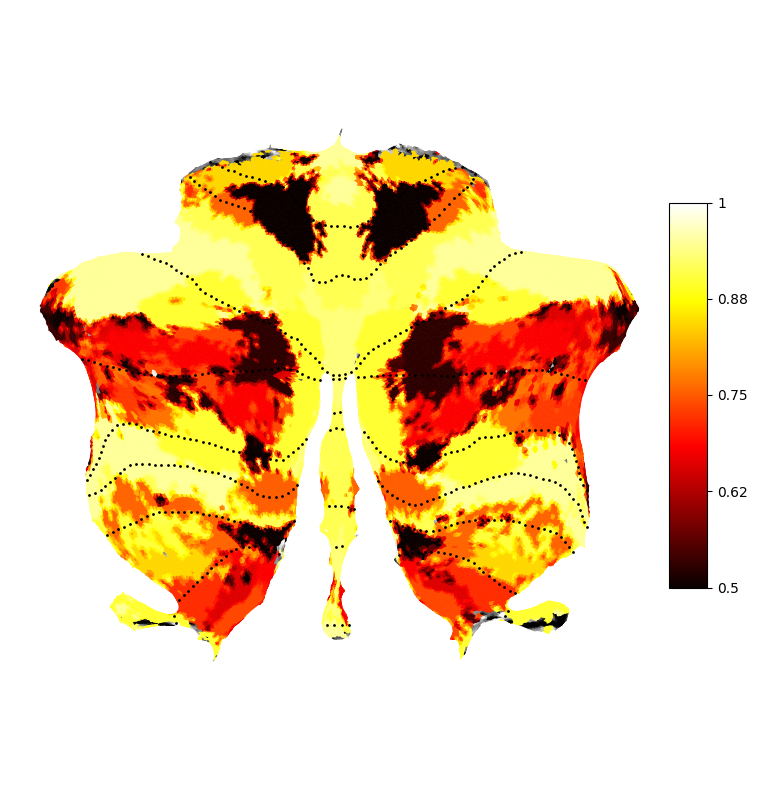

In [8]:
# Get prarcellation 
suit_atlas, _ = am.get_atlas(split_mn[2].split(
    'space-')[1], ut.base_dir + '/Atlases')
# Convert dtype to float32
Nifti = suit_atlas.data_to_nifti(parcel.astype(np.float32))

# Map the symmetry to the parcels   
surf_parcel = suit.flatmap.vol_to_surf(Nifti, stats='mode',
                                       space='MNISymC', ignore_zeros=True)
surf_parcel = np.nan_to_num(surf_parcel, copy=False).astype(int)
sym_map = np.zeros(surf_parcel.shape) * np.nan
sym_map[surf_parcel > 0] = sym_score[surf_parcel[surf_parcel > 0] - 1]

# Plot the symmetry map
plt.figure(figsize=(10, 10))
suit.flatmap.plot(sym_map,
                    render='matplotlib',
                    overlay_type='func',
                    new_figure=False,
                    colorbar=True,
                    cscale=cscale,
                    cmap=cmap)
plt.savefig(figure_path + 'Symmetry_profile_group.png',
            dpi=300, bbox_inches='tight')


# Individual Asymmetry

## Boundary Asymmetry (Individual)


In [9]:
asym_sym_corr_indiv = np.load(
    f'{ut.model_dir}/Models/{model_pair[0]}_asym_sym_corr_indiv.npy')


In [10]:
# Load number of participants
T = pd.read_csv(ut.base_dir + '/dataset_description.tsv', sep='\t')
n_subjects = T.num_particpants[:7].values
# Make index start at 0
sub_cumulative = np.cumsum(n_subjects)-1
# print(sub_cumulative)


In [11]:
# Loop through n_subjects and group correlation by dataset
corr_dataset = []
for i in range(len(n_subjects)):
    # print subjects to average to check subject indexing is correct
    if i == 0:
        # print(sub_cumulative[i])
        corr_dataset.append(asym_sym_corr_indiv[:sub_cumulative[i]].mean(axis=0))
    else:
        # print(sub_cumulative[i-1]+1, sub_cumulative[i])
        corr_dataset.append(
            asym_sym_corr_indiv[sub_cumulative[i-1]+1:sub_cumulative[i]].mean(axis=0))


In [1]:
# Plot the results by dataset
plt.figure(figsize=(20, 20))
ut.plot_data_flat(corr_dataset[T.two_letter_code.tolist().index('Md')
                               ], 'MNISymC2',
                   dtype='func',
                   colorbar=True,
                   cscale=(0.5, 1),
                   cmap='hot')
plt.savefig(figure_path + 'Symmetry_boundary_individual.png',
            dpi=300, bbox_inches='tight')


NameError: name 'plt' is not defined

## Average only symmetric datasets (Md, Po, Wm, De, So)

In [20]:
# Average symmetric datasets
symmetric_datasets = ['Md', 'Po', 'Wm', 'De', 'So']
# Get indices of symmetric datasets
symmetric_indices = [i for i, x in enumerate(T.two_letter_code) if x in symmetric_datasets]

# Collect only numpy arrays from symmetric indices
corr_dataset_sym = [corr_dataset[i] for i in symmetric_indices]

# Stack
corr_dataset_sym = np.stack(corr_dataset_sym, axis=0)
# Average
corr_dataset_sym = corr_dataset_sym.mean(axis=0)


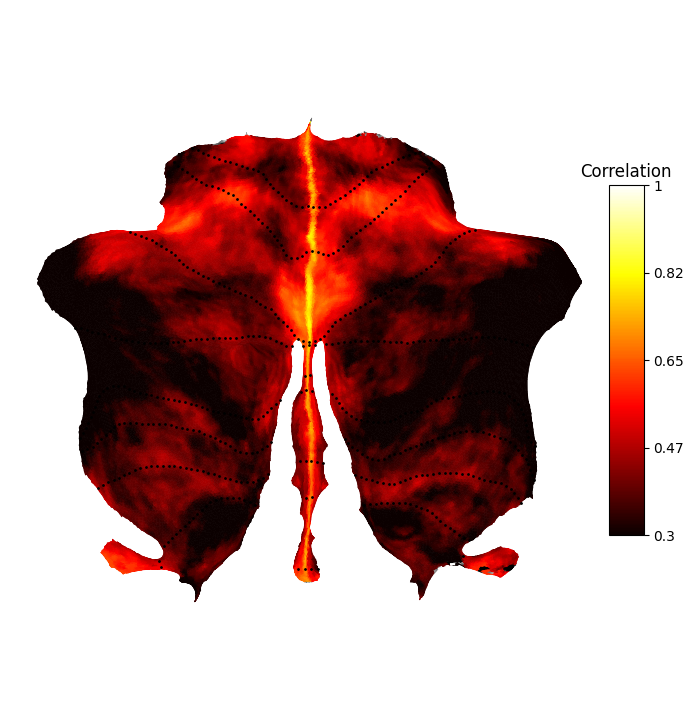

In [22]:
plt.figure(figsize=(20, 20))
ut.plot_multi_flat([corr_dataset_sym], 'MNISymC2',
                   grid=(2, 2),
                   dtype='func',
                   colorbar=True,
                   cscale=cscale,
                   cmap='hot',
                    titles=['Correlation'])
plt.savefig(figure_path + 'Symmetry_boundary_symmetric-datasets.png',
            dpi=300, bbox_inches='tight')
